#### Reference by : https://github.com/herbwood/pytorch_faster_r_cnn/blob/main/faster_r_cnn.ipynb

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import json 

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
    
else:
    DEVICE = torchc.device("cpu")
    print(DEVICE)

cuda Quadro RTX 6000


# Data Preprocessing

## 1) Visualize Image and bounding boxes

### 1. Data load & Visualization

(3024, 4032, 3)


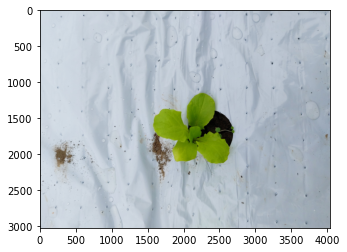

In [4]:
img0 = cv2.imread("/home/ubuntu/Project/data/V006_77_0_00_05_03_11_0_b04_20201119_0000_S01_1.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

#### 2. Load Bounding boxes data

In [16]:
with open('/home/ubuntu/Project/data/V006_77_0_00_05_03_11_0_b04_20201119_0000_S01_1.jpg.json','r')as file:
    data = json.load(file)
    
bbox0 = np.array([data["annotations"]["points"][0]['xtl'],
                data["annotations"]["points"][0]['ytl'],
                data["annotations"]["points"][0]['xbr'],
                data["annotations"]["points"][0]['ybr'],])
labels = np.array(data["annotations"]["disease"])

#### 3. Display bounding boox and labels

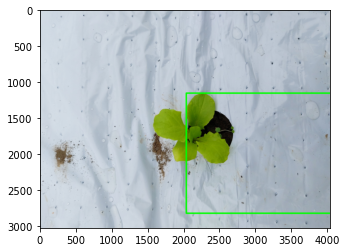

In [17]:
img0_clone = np.copy(img0)

cv2.rectangle(img0_clone, (bbox0), color = (0,255,0), thickness = 20)
    
plt.imshow(img0_clone)
plt.show()